In [178]:

from pathlib import Path
from osgeo import gdal
import rasterio.plot
import geopandas as gpd
from requests import Request
import matplotlib.pyplot as plt
from rasterio.mask import mask

## 0. Creation de la mosaique

In [96]:
path = Path('data/input/ORTHOHR_1-0_IRC-0M20_JP2-E080_LAMB93_D091_2021-01-01/ORTHOHR/1_DONNEES_LIVRAISON_2022-06-00154/OHR_IRC_0M20_JP2-E080_LAMB93_D91-2021')
vrt_path = 'data/intermediate/orthophoto91-mosaic.vrt'

In [97]:
filepaths = [str(x) for x in path.rglob('*.jp2')]  # list of paths to raster files
  # path to vrt to build
ds = gdal.BuildVRT(vrt_path, filepaths)
ds.FlushCache()

## 1. Collection des données BD Topo

In [173]:
code_insee = '91339'
base_url = 'https://wxs.ign.fr/topographie/geoportail/wfs?'
params = {
    'version' : '2.0.0',
    'request' : 'GetFeature',
    'typeName' : 'BDTOPO_V3:commune',
    'filter' : f'<Filter><PropertyIsEqualTo><PropertyName>code_insee</PropertyName><Literal>{code_insee}</Literal></PropertyIsEqualTo></Filter>',
    'outputFormat' : 'json'
}


# Parse the URL with parameters
wfs_request_url = Request('GET', base_url, params=params).prepare().url
commune = gpd.read_file(wfs_request_url)
commune.to_crs(epsg=2154, inplace=True)


## 2. Decouper BD Ortho 

In [176]:
mosaic_path = 'data/input/ORTHOHR_1-0_IRC-0M20_JP2-E080_LAMB93_D091_2021-01-01/ORTHOHR/3_SUPPLEMENTS_LIVRAISON_2022-06-00154/OHR_IRC_0M20_JP2-E080_LAMB93_D91-2021/mosaique_POSIX.vrt'
with rasterio.open(vrt_path) as raster_vrt:
    cropped, crop_trans = mask(raster_vrt, [commune.iloc[0].geometry], crop=True)

<AxesSubplot:>

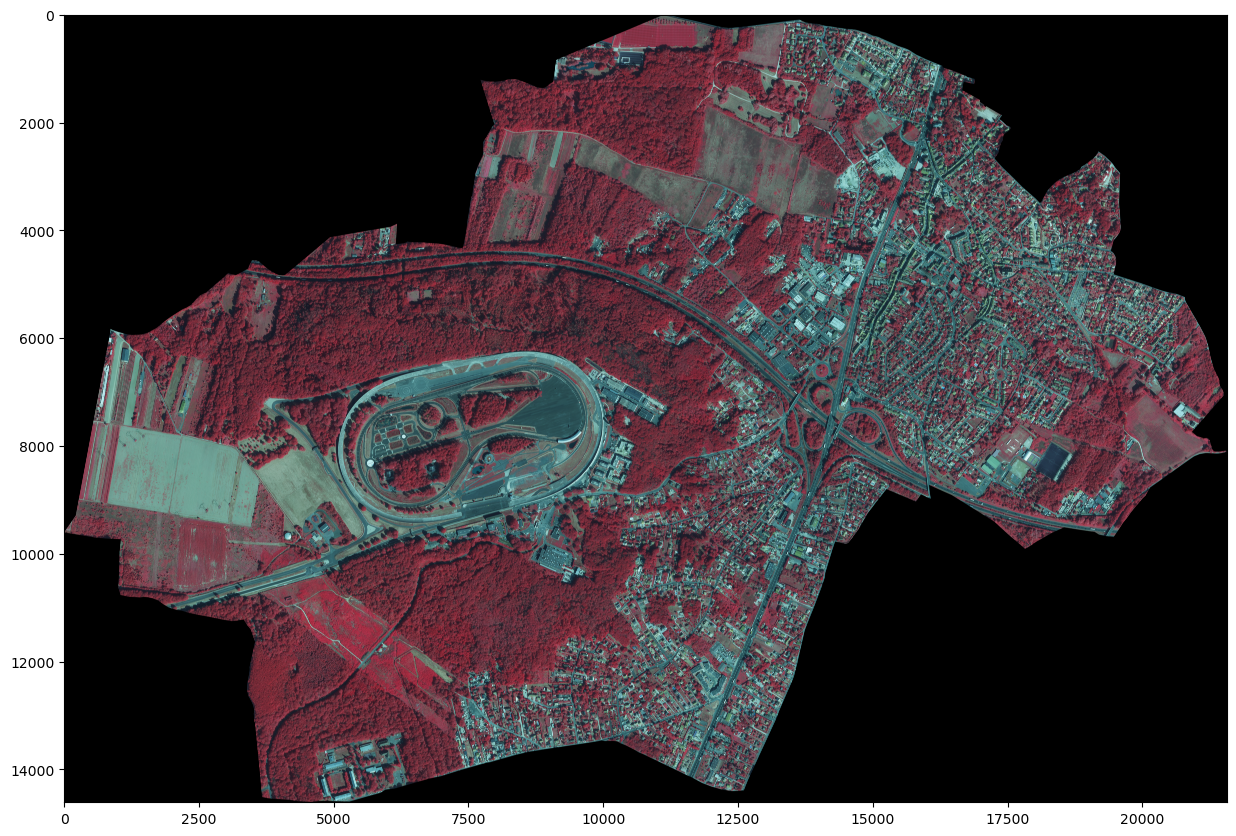

In [177]:
fig, ax = plt.subplots(figsize=(15, 15))
rasterio.plot.show(cropped, ax=ax)